## **EN3150 Assignment 03:**
### **Simple convolutional neural network to perform classification.**

In [20]:
# Import necessary Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from torchvision.models import ResNet18_Weights
from torchvision.models import VGG16_Weights


In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Data preparation
data_dir = r"C:\Users\ADMIN\Desktop\Mora\Image Dataset\realwaste-main\RealWaste"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
print("Classes:", class_names)

# Split 70/15/15
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len
train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

# DataLoaders optimized for your hardware
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [23]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * (224 // 8) * (224 // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [24]:
# Training and evaluation functions
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                val_loss += criterion(model(inputs), labels).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    return acc, prec, rec, f1, cm, cr

In [ ]:
# Train the model with optimizers Adam, SGD and SGD with momentum
# Count images in each class
counts = Counter(full_dataset.targets)  # or use folder count for ImageFolder
total = sum(counts.values())
class_weights = [total / counts[c] for c in range(len(counts))]

weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


optimizers = {
    "Adam": lambda params: optim.Adam(params, lr=0.001),
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "SGD+Momentum": lambda params: optim.SGD(params, lr=0.01, momentum=0.9)
}

results = {}
for name, opt_fn in optimizers.items():
    print(f"\n===== Training with {name} =====")
    model = SimpleCNN().to(device)
    optimizer = opt_fn(model.parameters())
    train_losses, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20)
    acc, prec, rec, cm = evaluate_model(model, test_loader)
    results[name] = (acc, prec, rec, cm)
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(f'{name} Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Adam Results:
Accuracy: 69.33% | Precision: 0.686 | Recall: 0.681


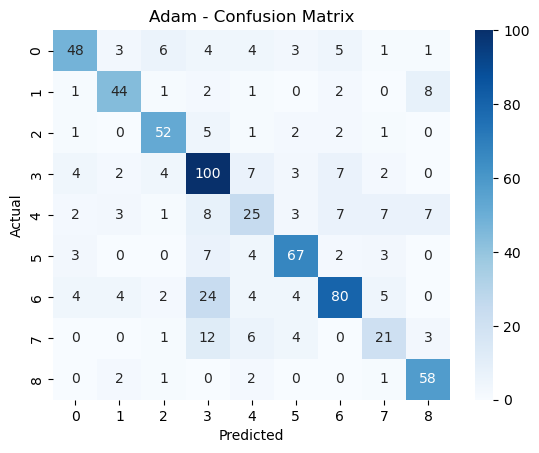

In [7]:
# Results 
for name, (acc, prec, rec, cm) in results.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc*100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()


===== Fine-tuning ResNet18 =====
Epoch [1/10]  Train Loss: 0.8218 | Val Loss: 0.4728
Epoch [2/10]  Train Loss: 0.2081 | Val Loss: 0.3615
Epoch [3/10]  Train Loss: 0.0533 | Val Loss: 0.3325
Epoch [4/10]  Train Loss: 0.0213 | Val Loss: 0.3443
Epoch [5/10]  Train Loss: 0.0119 | Val Loss: 0.3270
Epoch [6/10]  Train Loss: 0.0062 | Val Loss: 0.3380
Epoch [7/10]  Train Loss: 0.0038 | Val Loss: 0.3517
Epoch [8/10]  Train Loss: 0.0036 | Val Loss: 0.3613
Epoch [9/10]  Train Loss: 0.0029 | Val Loss: 0.3650
Epoch [10/10]  Train Loss: 0.0021 | Val Loss: 0.3660
Accuracy: 88.66% | Precision: 0.885 | Recall: 0.886 | F1-Score:  0.884


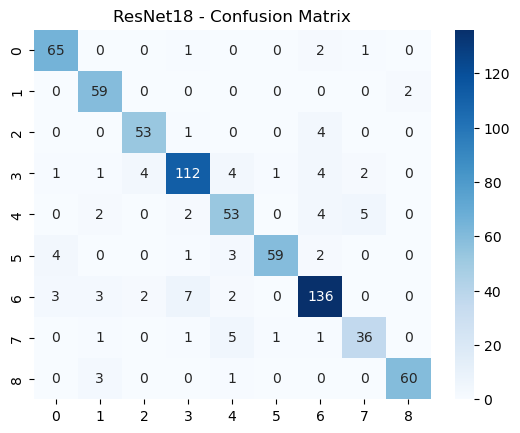

Per-class performance:
                     precision    recall  f1-score   support

          Cardboard       0.89      0.94      0.92        69
      Food Organics       0.86      0.97      0.91        61
              Glass       0.90      0.91      0.91        58
              Metal       0.90      0.87      0.88       129
Miscellaneous Trash       0.78      0.80      0.79        66
              Paper       0.97      0.86      0.91        69
            Plastic       0.89      0.89      0.89       153
      Textile Trash       0.82      0.80      0.81        45
         Vegetation       0.97      0.94      0.95        64

           accuracy                           0.89       714
          macro avg       0.88      0.89      0.88       714
       weighted avg       0.89      0.89      0.89       714


===== Fine-tuning VGG16 =====
Epoch [1/10]  Train Loss: 1.0876 | Val Loss: 0.6933
Epoch [2/10]  Train Loss: 0.6932 | Val Loss: 0.6288
Epoch [3/10]  Train Loss: 0.6015 | Val Loss: 0

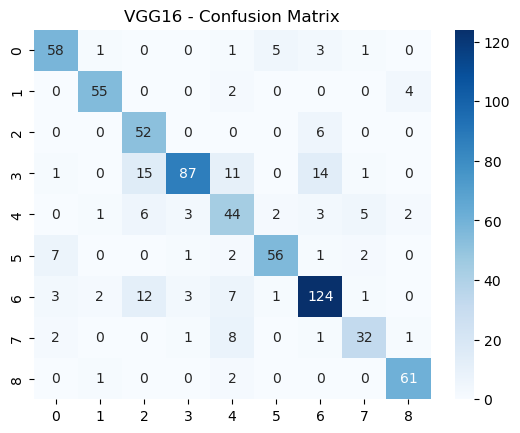

Per-class performance:
                     precision    recall  f1-score   support

          Cardboard       0.82      0.84      0.83        69
      Food Organics       0.92      0.90      0.91        61
              Glass       0.61      0.90      0.73        58
              Metal       0.92      0.67      0.78       129
Miscellaneous Trash       0.57      0.67      0.62        66
              Paper       0.88      0.81      0.84        69
            Plastic       0.82      0.81      0.81       153
      Textile Trash       0.76      0.71      0.74        45
         Vegetation       0.90      0.95      0.92        64

           accuracy                           0.80       714
          macro avg       0.80      0.81      0.80       714
       weighted avg       0.81      0.80      0.80       714



In [25]:
# Transfer learning using ResNet18
print("\n===== Fine-tuning ResNet18 =====")
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Unfreeze last block (layer4) + FC for better adaptation
for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(class_names))
resnet = resnet.to(device)

# Use discriminative learning rates
optimizer_ft = optim.Adam([
    {'params': resnet.layer4.parameters(), 'lr': 1e-4},
    {'params': resnet.fc.parameters(), 'lr': 1e-3}
])

train_model(resnet, optimizer_ft, criterion, train_loader, val_loader, epochs=10)
acc_ft, prec_ft, rec_ft, f1_ft, cm_ft, cr_ft = evaluate_model(resnet, test_loader)
print(f"Accuracy: {acc_ft*100:.2f}% | Precision: {prec_ft:.3f} | Recall: {rec_ft:.3f} | F1-Score:  {f1_ft:.3f}")

# Plot Confusion Matrix
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues')
plt.title('ResNet18 - Confusion Matrix')
plt.show()

print("Per-class performance:")
print(cr_ft)

# Transfer Learning using VGG16
print("\n===== Fine-tuning VGG16 =====")
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in vgg16.parameters():
    param.requires_grad = False
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))

for name, param in vgg16.classifier.named_parameters():
    if "6" in name:  # layer 6 = last linear + dropout
        param.requires_grad = True
    else:
        param.requires_grad = False
vgg16 = vgg16.to(device)

optimizer_ft = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)
train_model(vgg16, optimizer_ft, criterion, train_loader, val_loader, epochs=10)
acc_vgg, prec_vgg, rec_vgg, f1_vgg, cm_vgg, cr_vgg = evaluate_model(vgg16, test_loader)
print(f"VGG16 Fine-tuned Accuracy: {acc_vgg*100:.2f}% | Precision: {prec_vgg:.3f} | Recall: {rec_vgg:.3f} | F1-Score:  {f1_vgg:.3f}")

# Plot Confusion Matrix
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues')
plt.title('VGG16 - Confusion Matrix')
plt.show()

print("Per-class performance:")
print(cr_vgg)